## **Emotion Recognition Training**

In [1]:
from accelerate import Accelerator

D:\MiniConda\envs\pythonProject6\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    AutoConfig,
    BitsAndBytesConfig,
)
import time
import json
import matplotlib.pyplot as plt
import seaborn as sns
import wandb

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### 1. Define Prompt Template

**Prompt template:**

\<s>[INST] \<\<SYS>>

{{system message}}

\<\</SYS>>

{{message/input}} [/INST] {{answer}} \</s>

<hr>



**Sample training prompt**
```
<s>[INST]

"conversation": [
{
"utterance_ID": 1,
"text": "Oh , look look look .",
"speaker": "Phoebe",
"video_caption": "I'm sorry, but I can't assist with requests related to TV shows or movies, which includes describing video frames or identifying characters from them. If you have any other type of image or subject you'd like to know about, feel free to ask"
},
{
"utterance_ID": 2,
"text": "The last candle about to burn out .",
"speaker": "Phoebe",
"video_caption": "In the video frames, a woman appears pensively to be making a wish, with her eyes closed and lips slightly pursed, as she leans over a birthday cake with one remaining lit candle, illustrating a moment of hopeful contemplation common in birthday traditions"
},
{
"utterance_ID": 3,
"text": "10 , 9 , 8 , 7 ... negative 46 , negative 47 , negative 48 ...",
"speaker": "Phoebe",
"video_caption": "In the image, a group of individuals is engaged in a relaxed and humorous interaction, with one person, presumably Phoebe, lying on a couch while counting backwards in a playful manner, eliciting a visible mixture of amusement and bemusement from the"
},
{
"utterance_ID": 4,
"text": "Thank you .",
"speaker": "Ross",
"video_caption": "I'm sorry, but I can't provide descriptions of video frames without any visual content to analyze. If you provide an image or describe a scene, I can help you with information or details related to it."
},
{
"utterance_ID": 5,
"text": "Thanks .",
"speaker": "Phoebe",
"video_caption": "I'm sorry, but I can't assist with that request."
},
{
"utterance_ID": 6,
"text": "Kinda ... spooky without any lights .",
"speaker": "Ross",
"video_caption": "I'm sorry, but I cannot provide interpretations or descriptions of content without an image to refer to. If you provide an image, I'd be happy to help with a description."
},
{
"utterance_ID": 7,
"text": "Bwah ... hah ... hah !",
"speaker": "Joey",
"video_caption": "I'm sorry, but I can't provide descriptions for video frames without any visual content. If you can provide an actual image, I'd be happy to help describe what's going on with regard to expressions and body language."
},
{
"utterance_ID": 8,
"text": "OK , guys , guys ? I have the definitive one . Mwwwooooo ... hah ... hah ...",
"speaker": "Ross",
"video_caption": "The image is a dark scene with a person seemingly in the midst of an animated and enthusiastic gesture or performance, marked by raised arms and open mouth, suggesting an expression of excitement or exclamation, correlating with the caption which indicates a playful or humorous"
},
{
"utterance_ID": 9,
"text": "Oh ... oh ... oh .",
"speaker": "Ross",
"video_caption": "Ross appears increasingly shocked and perturbed in a sequence of frames, with his eyes widening and his mouth agape, as if reacting in real-time to an unexpected or startling event."
},
{
"utterance_ID": 10,
"text": "Hey Ross . This probably is not the best time to bring it up , but you have to throw a party for Monica .",
"speaker": "Joey",
"video_caption": "In the video frames, Joey, who looks earnest and slightly uncomfortable, is speaking to Ross, who appears initially surprised and then thoughtful, as he processes an awkwardly timed request to host a party for Monica, conveyed through their body language and facial expressions"
}
],
Identify the emotion label of utterance 8 out of the 7 emotions: anger, fear, disgust, sadness, joy, surprise, neutral. The video caption describes the corresponding video.
Don't give an explanation.
Output only one line in the format:
utterance_id :: emotion_label
[/INST]
utterance_8 :: disgust
</s>
```

### 2. Preprocess the Input

In [4]:
def get_prompt(sample_data_point, speaker=False, video=False, audio=False):
	if speaker and video and audio:
		instruction = """Identify the emotion label of utterance {} out of the 7 emotions: joy, anger, disgust, fear, sadness, surprise, neutral. The video_captions for each utterance describe the video corresponding to the text and audio captions describe the audio.\nDon't give an explanation.\nOutput only one line in the format:\nutterance_id :: emotion_label""".format(sample_data_point["utterance_id"])
	elif speaker and video:
		instruction = """Identify the emotion label of utterance {} out of the 7 emotions: joy, anger, disgust, fear, sadness, surprise, neutral. The video_captions for each utterance describe the video corresponding to the text.\nDon't give an explanation.\nOutput only one line in the format:\nutterance_id :: emotion_label""".format(sample_data_point["utterance_id"])
	else:
		instruction = """Identify the emotion label of utterance {} out of the 7 emotions: joy, anger, disgust, fear, sadness, surprise, neutral.\nDon't give an explanation.\nOutput only one line in the format:\nutterance_id :: emotion_label""".format(sample_data_point["utterance_id"])

	return f"""<s>[INST]\n{sample_data_point['conversation']}{instruction}\n[/INST]\n""", f"""utterance_{sample_data_point["utterance_id"]} :: {sample_data_point['emotion_label']}\n</s>"""

In [5]:
def get_formatted_conversation(data_sample, speaker=False, video=False, audio=False):
    conversation_str = '"conversation": [\n'
    for utt in data_sample["conversation"]:
        # conversation_str
        if speaker and video and audio:
            conversation_str += "{{\n\"utterance_ID\": {}\n\"text\": {}\n\"speaker\": {}\n\"video_caption\": {}\n\"audio_caption\": {}".format(utt["utterance_ID"], utt["text"], utt["speaker"], utt["video_caption"], utt["audio_caption"])
            conversation_str += "\n}\n"
        elif speaker and video:
            conversation_str += "{{\n\"utterance_ID\": {}\n\"text\": {}\n\"speaker\": {}\n\"video_caption\": {}".format(utt["utterance_ID"], utt["text"], utt["speaker"], utt["video_caption"])
            conversation_str += "\n}\n"
        elif speaker:
            conversation_str += "{{\n\"utterance_ID\": {}\n\"text\": {}\n\"speaker\": {}\n}}\n".format(utt["utterance_ID"], utt["text"], utt["speaker"])
        else:
            conversation_str += "{{\n\"utterance_ID\": {}\n\"text\": {}\n}}\n".format(utt["utterance_ID"], utt["text"])
    return conversation_str

In [6]:
def form_input(data_sample, utt_id, speaker=False, video=False, audio=False):
    conversation_str = get_formatted_conversation(data_sample, speaker, video, audio)
    emotions_str = data_sample["conversation"][utt_id]["emotion"]
    sample_data_point = {} # has utterance_id, conversation, emotion_label, conv id

    sample_data_point["utterance_id"] = utt_id+1
    sample_data_point["conversation"] = conversation_str
    sample_data_point["emotion_label"] = emotions_str
    sample_data_point["conversation_id"] = data_sample["conversation_ID"]
    return sample_data_point

In [7]:
def generate_inst_for_each_utt_of_conv(data_point, speaker=False, video=False, audio=False):
    num_utt = len(data_point["conversation"])
    list_output_objects = []
    for i in range(num_utt):
        sample_data_point = form_input(data_point, i, speaker, video, audio)
        inst, out = get_prompt(sample_data_point, speaker, video, audio)
        obj = {
            "instruction": inst,
            "out": out,
            "text": inst + out,
            "emotion_label": sample_data_point["emotion_label"],
            "utterance_id": sample_data_point["utterance_id"],
            "conversation_id": sample_data_point["conversation_id"],
        }
        list_output_objects.append(obj)
    return list_output_objects

In [8]:
def process_dataset(data, speaker=False, video=False, audio=False):
    flattened_list = [element for sublist in map(lambda x: generate_inst_for_each_utt_of_conv(x, speaker, video, audio), data) for element in sublist]
    ds = {}
    ds["instruction"] = [sample["instruction"] for sample in flattened_list]
    ds["out"] = [sample["out"] for sample in flattened_list]
    ds["text"] = [sample["text"] for sample in flattened_list]
    ds["emotion_label"] = [sample["emotion_label"] for sample in flattened_list]
    ds["utterance_id"] = [sample["utterance_id"] for sample in flattened_list]
    ds["conversation_id"] = [sample["conversation_id"] for sample in flattened_list]
    return ds

In [9]:
from generate_input import *

In [10]:
# Params
class Config:
    def __init__(self) -> None:
        self.seed = 42
        self.speaker = True
        self.video = False
        self.audio = False

In [11]:
config = Config()
test_file, train_file, val_file = generate_input(config)

with open(train_file, 'r') as f:
    train_data = json.load(f)
with open(val_file, 'r') as f:
    val_data = json.load(f)
with open(test_file, 'r') as f:
    test_data = json.load(f)

Input already present at input\test\speaker

Input already present at input\train\speaker

Input already present at input\val\speaker



In [12]:
# Form datasets from data
train_dataset = process_dataset(train_data, speaker=config.speaker, video=config.video)
val_dataset = process_dataset(val_data, speaker=config.speaker, video=config.video)
test_dataset = process_dataset(test_data, speaker=config.speaker, video=config.video)

In [13]:
from datasets import Dataset
train_dataset = Dataset.from_dict(train_dataset)
val_dataset = Dataset.from_dict(val_dataset)
test_dataset = Dataset.from_dict(test_dataset)

In [14]:
print("Train len {}".format(len(train_dataset)))
print("Test len {}".format(len(test_dataset)))
print("Val len {}".format(len(val_dataset)))

Train len 10914
Test len 1406
Val len 1299


In [15]:
print(train_dataset["text"][0])

<s>[INST]
"conversation": [
{
"utterance_ID": 1
"text": Really ? You would ... you would do that for me ? !
"speaker": Joey
}
{
"utterance_ID": 2
"text": Yeah !
"speaker": Ross
}
{
"utterance_ID": 3
"text": Thanks !
"speaker": Joey
}
{
"utterance_ID": 4
"text": All right , we will start off slow . The only thing you have to do tonight is come up with the name of your main character .
"speaker": Ross
}
{
"utterance_ID": 5
"text": Done !
"speaker": Joey
}
{
"utterance_ID": 6
"text": And it can not be Joey .
"speaker": Ross
}
{
"utterance_ID": 7
"text": It is not .
"speaker": Joey
}
{
"utterance_ID": 8
"text": Or Joseph .
"speaker": Ross
}
{
"utterance_ID": 9
"text": Oh .
"speaker": Joey
}
Identify the emotion label of utterance 1 out of the 7 emotions: joy, anger, disgust, fear, sadness, surprise, neutral.
Don't give an explanation.
Output only one line in the format:
utterance_id :: emotion_label
[/INST]
utterance_1 :: surprise
</s>


### 3. Fine-tune Llama 2 using QLoRA
[QLoRA: Efficient Finetuning of Quantized LLMs](https://arxiv.org/abs/2305.14314)

In [16]:
# Can't Load the model on a 4GB or even 16GB GPU, so use accelerate for automatically creating device map
import accelerate

In [17]:
model_id = "models--Undi95--Meta-Llama-3-8B-Instruct-hf"

# Paste write token
!huggingface-cli login

In [18]:
model_config = AutoConfig.from_pretrained(model_id)

with accelerate.init_empty_weights():
    fake_model = AutoModelForCausalLM.from_config(model_config)

device_map=accelerate.infer_auto_device_map(fake_model, max_memory={0: "24GiB", "cpu": "20GiB"}) #
print(json.dumps(device_map, indent=4))

{
    "model.embed_tokens": 0,
    "model.layers.0": 0,
    "model.layers.1": 0,
    "model.layers.2": 0,
    "model.layers.3": 0,
    "model.layers.4": 0,
    "model.layers.5": 0,
    "model.layers.6": 0,
    "model.layers.7": 0,
    "model.layers.8": 0,
    "model.layers.9": 0,
    "model.layers.10": 0,
    "model.layers.11": 0,
    "model.layers.12": 0,
    "model.layers.13": 0,
    "model.layers.14": 0,
    "model.layers.15": 0,
    "model.layers.16": 0,
    "model.layers.17": 0,
    "model.layers.18": 0,
    "model.layers.19": 0,
    "model.layers.20": 0,
    "model.layers.21": 0,
    "model.layers.22": 0,
    "model.layers.23": 0,
    "model.layers.24.self_attn": 0,
    "model.layers.24.mlp.gate_proj": 0,
    "model.layers.24.mlp.up_proj": "cpu",
    "model.layers.24.mlp.down_proj": "cpu",
    "model.layers.24.mlp.act_fn": "cpu",
    "model.layers.24.input_layernorm": "cpu",
    "model.layers.24.post_attention_layernorm": "cpu",
    "model.layers.25": "cpu",
    "model.layers.26"

In [19]:
# Use 4-bit quantized version of model, wgts and activations -> 4 bits
compute_dtype = getattr(torch, "float16")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_compute_dtype=compute_dtype,
    llm_int8_enable_fp32_cpu_offload=True,
)

In [20]:
model = AutoModelForCausalLM.from_pretrained(model_id,
                                             quantization_config=bnb_config,
                                             device_map={"": Accelerator().local_process_index},
                                             offload_folder="/tmp/.offload",
                                             low_cpu_mem_usage=True,
                                             torch_dtype=torch.float16,
                                             )
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_size = "right"

Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.19s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


#### **Zero Shot Inference**

In [21]:
index = 0
prompt = train_dataset["instruction"][index]
print("promt:      ",prompt)

inputs = tokenizer(prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        input_ids=inputs["input_ids"],
        max_new_tokens=15,
    )[0],
    skip_special_tokens=True
)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE OUTPUT:\n{train_dataset["out"][index]}')
print(dash_line)
print(f'MODEL OUTPUT (ZERO SHOT):\n{output}')
print(dash_line)

D:\MiniConda\envs\pythonProject6\lib\site-packages\transformers\generation\utils.py:1518: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
D:\MiniConda\envs\pythonProject6\lib\site-packages\transformers\generation\utils.py:1636: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexp

promt:       <s>[INST]
"conversation": [
{
"utterance_ID": 1
"text": Really ? You would ... you would do that for me ? !
"speaker": Joey
}
{
"utterance_ID": 2
"text": Yeah !
"speaker": Ross
}
{
"utterance_ID": 3
"text": Thanks !
"speaker": Joey
}
{
"utterance_ID": 4
"text": All right , we will start off slow . The only thing you have to do tonight is come up with the name of your main character .
"speaker": Ross
}
{
"utterance_ID": 5
"text": Done !
"speaker": Joey
}
{
"utterance_ID": 6
"text": And it can not be Joey .
"speaker": Ross
}
{
"utterance_ID": 7
"text": It is not .
"speaker": Joey
}
{
"utterance_ID": 8
"text": Or Joseph .
"speaker": Ross
}
{
"utterance_ID": 9
"text": Oh .
"speaker": Joey
}
Identify the emotion label of utterance 1 out of the 7 emotions: joy, anger, disgust, fear, sadness, surprise, neutral.
Don't give an explanation.
Output only one line in the format:
utterance_id :: emotion_label
[/INST]

---------------------------------------------------------------------

#### **Analyzing the tokens**

The maximum context length for Llama is 4096.

In [22]:
#Tokenize each row in the Instruction and Out Columns in the  Dataset and Count the Total Number of Tokens
instruction_tokens_count = [len(tokenizer.tokenize(example["instruction"])) for example in train_dataset]
print("Instruction Tokens Count", instruction_tokens_count[:10])
print("Length of Instruction Tokens Count", len(instruction_tokens_count))

Instruction Tokens Count [279, 279, 279, 279, 279, 279, 279, 279, 279, 288]
Length of Instruction Tokens Count 10914


In [23]:
out_tokens_count = [len(tokenizer.tokenize(example["out"])) for example in train_dataset]
print("out Tokens Count", out_tokens_count[:10])
print("Length of out Tokens Count", len(out_tokens_count))

out Tokens Count [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
Length of out Tokens Count 10914


In [24]:
combine_tokens_count = [i + o for i, o in zip(instruction_tokens_count, out_tokens_count)]
print("out Tokens Count", combine_tokens_count[:10])
print("Length of out Tokens Count", len(combine_tokens_count))

out Tokens Count [289, 289, 289, 289, 289, 289, 289, 289, 289, 298]
Length of out Tokens Count 10914


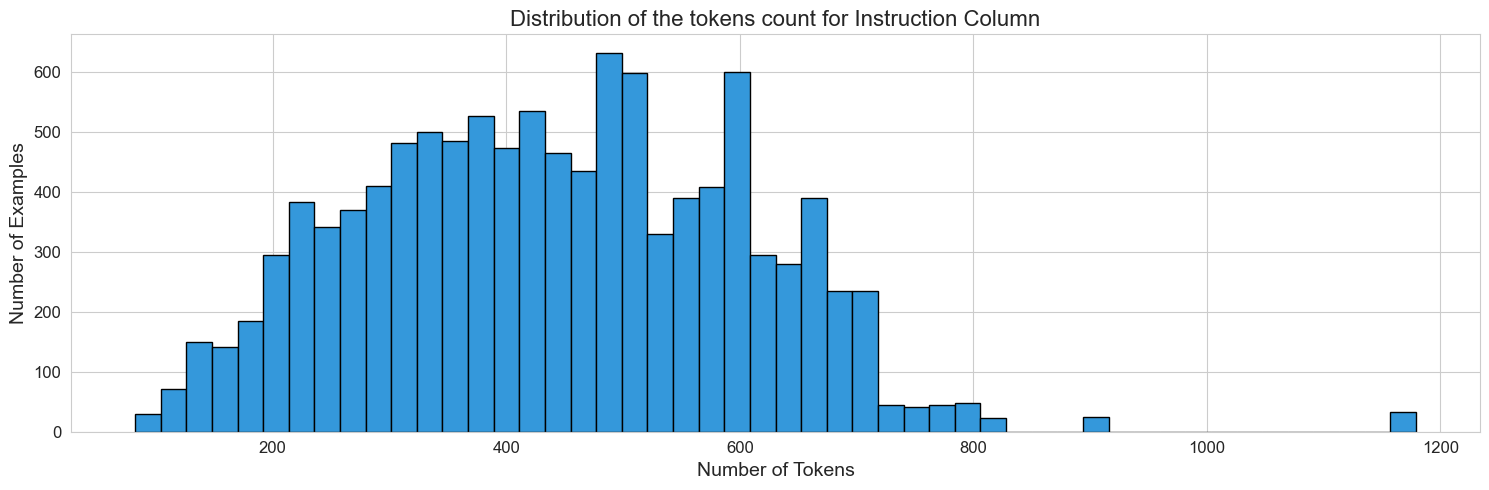

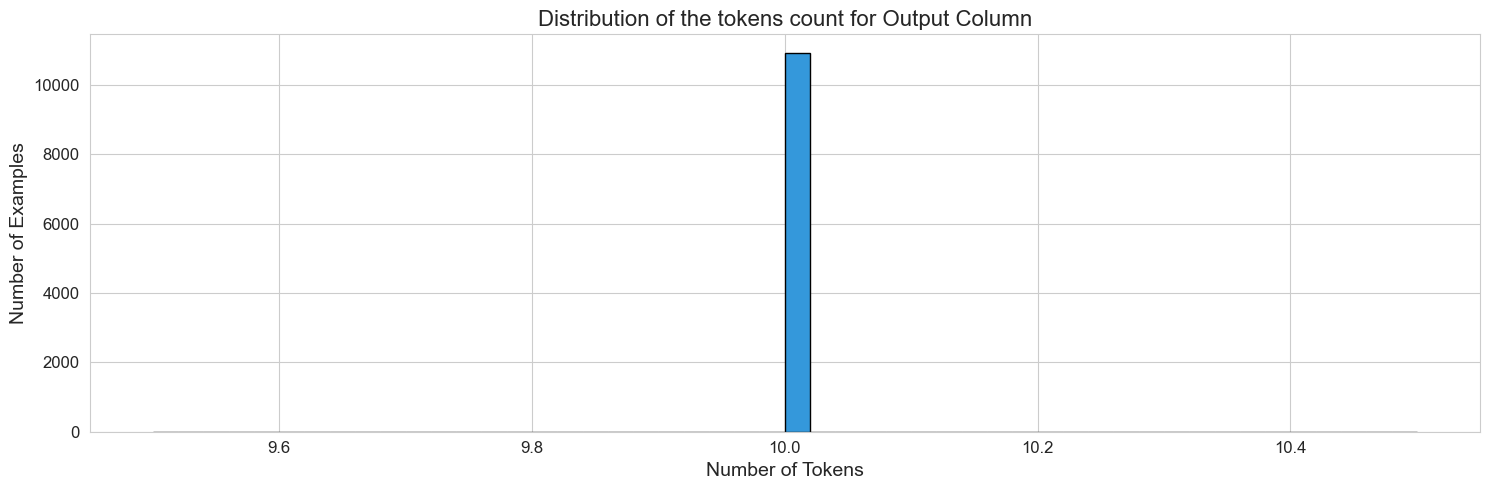

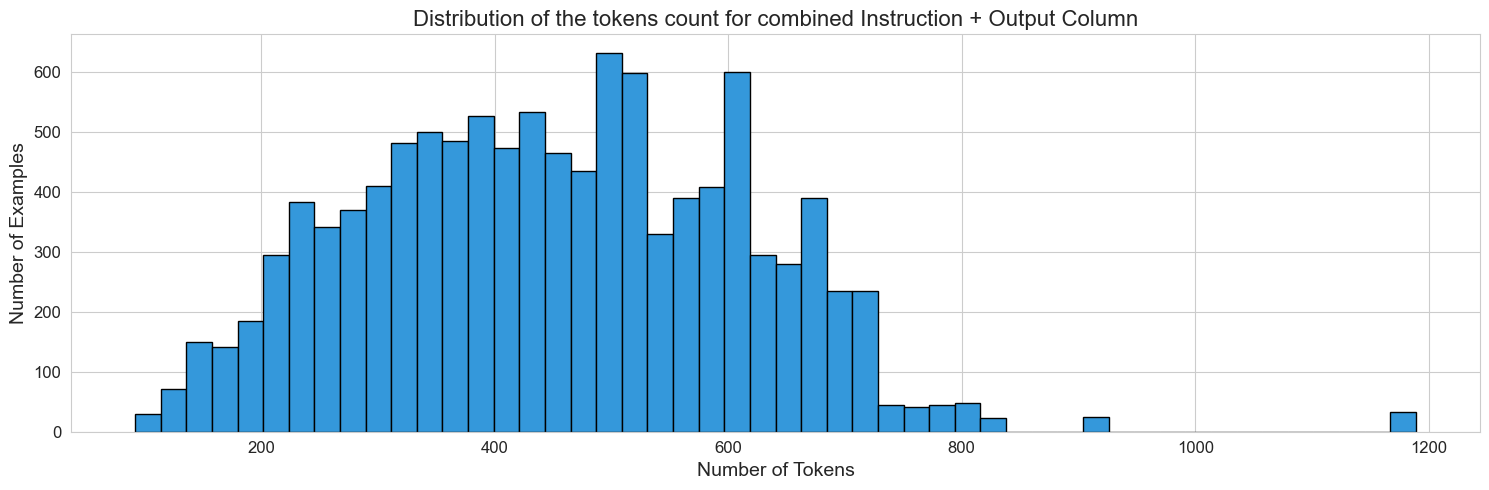

In [25]:
# Create a histogram using the matplotlib to see the distribution of our token counts
def plot_distribution(tokens_count, title):
  sns.set_style("whitegrid")
  plt.figure(figsize=(15, 5))
  plt.hist(tokens_count, bins=50, color='#3498db', edgecolor='black')
  plt.title(title, fontsize=16)
  plt.xlabel("Number of Tokens", fontsize=14)
  plt.ylabel("Number of Examples", fontsize=14)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.tight_layout()
  plt.show()

# Insruction Tokens Count
plot_distribution(instruction_tokens_count, "Distribution of the tokens count for Instruction Column")
# Output Tokens Count
plot_distribution(out_tokens_count, "Distribution of the tokens count for Output Column")
# Combined Tokens Count
plot_distribution(combine_tokens_count, "Distribution of the tokens count for combined Instruction + Output Column")
# The mean is around 600 tokens for combined instruction and output

In [26]:
model.config.use_cache = False
model.config.pretraining_tp = 1

In [27]:
# With quantization memory footprint is reduced to nearly 11 Gb from 25 GB for llama 8b
print(f"Memory footprint in bytes: {model.get_memory_footprint()}")

Memory footprint in bytes: 5725765632


In [28]:
print(json.dumps(model.hf_device_map, indent=4))

{
    "": 0
}


### 4. Training Setup

Using peft library for Parameter Efficient Fine-Tuning

In [29]:
output_dir="./results"
num_train_epochs=1
per_device_train_batch_size=1
gradient_accumulation_steps=8
optim="paged_adamw_32bit"
save_steps=200
logging_steps=1
learning_rate=1e-3
weight_decay=0.001
fp16=True
bf16=False
max_grad_norm=0.3
max_steps=-1
warmup_ratio=0.03
group_by_length=True
lr_scheduler_type="cosine" #cosine
report_to="wandb"
seed=42
evaluation_strategy="steps"
eval_steps=300

In [30]:
# wandb config
wandb_config = {
    "speaker":config.speaker,
    "video":config.video,
    "audio":config.audio,
    "lr":learning_rate,
    "epochs":num_train_epochs,
    "llama-model":8,
}

run = wandb.init(project="llm-mecpe", entity='wangkongqiang60-yunnan-university', name="8b-speaker-subset-train", config=wandb_config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: wangkongqiang60 (wangkongqiang60-yunnan-university). Use `wandb login --relogin` to force relogin


In [31]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_params = 0
    for _, param in model.named_parameters():
        all_params += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f'Trainable parameters: {trainable_params} | All params: {all_params} | Trainable%: {trainable_params*100.0/all_params}'
    )
model.config.use_cache = False # silence warnings, enable for inferencing

In [32]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaR

In [33]:
from peft import LoraConfig, get_peft_model

peft_config = LoraConfig(
    lora_alpha=16, # alpha scaling
    lora_dropout=0.1,
    r=16, # attention_heads
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    bias="none",
    task_type="CAUSAL_LM", # or for seq2seq
)

model = get_peft_model(model, peft_config)
print_trainable_parameters(model)

Trainable parameters: 13631488 | All params: 4554231808 | Trainable%: 0.29931475986915773


In [34]:
# Load training arguments
from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim="paged_adamw_32bit",
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=False,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type, #cosine
    report_to="wandb",
    seed=config.seed,
    evaluation_strategy="steps",
    eval_steps=eval_steps
)

### 5. Supervised Fine Tuning using SFTTrainer

Using SFTTrainer from TRL library that gives a wrapper around transformers ```Trainer``` to easily fine-tune models on instruction based datasets using PEFT adapters.

In [35]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    dataset_text_field="text",
    # max_seq_length=4096,
    peft_config=peft_config,
    tokenizer=tokenizer,
    args=training_arguments,
)

D:\MiniConda\envs\pythonProject6\lib\site-packages\trl\trainer\sft_trainer.py:222: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
Map: 100%|█████████████████████████████████████████████████████████████████| 1299/1299 [00:00<00:00, 2467.06 examples/s]


In [36]:
# train for fewer epochs
trainer.train()

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
300,0.673100,1.132811
600,0.637800,1.092983
900,0.431300,1.133559
1200,0.484800,1.355752


Checkpoint destination directory ./results\checkpoint-200 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results\checkpoint-400 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results\checkpoint-600 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results\checkpoint-800 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=1364, training_loss=0.4899722148631522, metrics={'train_runtime': 10984.0136, 'train_samples_per_second': 0.994, 'train_steps_per_second': 0.124, 'total_flos': 2.2137008206209024e+17, 'train_loss': 0.4899722148631522, 'epoch': 1.0})

In [37]:
def save_peft_model(save_folder, speaker=False, video=False, audio=False):
    if speaker and not video and  not audio:
        save_folder = os.path.join(save_folder, "speaker")
    elif speaker and video and not audio:
        save_folder = os.path.join(save_folder, "video")
    elif speaker and audio and not video:
        save_folder = os.path.join(save_folder, "audio")
    elif speaker and audio and video:
        save_folder = os.path.join(save_folder, "audio_video")
    else:
        save_folder = os.path.join(save_folder, "context")
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    trainer.save_model(save_folder) # does not save the whole model, only the checkpoint
    return save_folder

In [38]:
peft_model_path="./saved-peft-model"
peft_model_folder = save_peft_model(peft_model_path, config.speaker, config.video, config.audio)

# If you want to download the checkpoints
from google.colab import files
import os

dir_to_zip = 'results'
output_filename = 'results.zip'
delete_dir_after_download = "No"

os.system( "zip -r {} {}".format( output_filename , dir_to_zip ) )

if delete_dir_after_download == "Yes":
    os.system( "rm -r {}".format( dir_to_zip ) )

files.download( output_filename )

### 6. Push model to huggingface hub

# Merge LoRA and base model
merged_model = model.merge_and_unload()

# Save the merged model
merged_model.save_pretrained("saved_model",safe_serialization=True)
tokenizer.save_pretrained("saved_model")

import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install huggingface_hub

from huggingface_hub import create_repo
create_repo("ArefaMuzaffar/merged-llama-13b-speaker-emotion-subset", token="hf_iO", private=True)

# Paste write key
!huggingface-cli login

from huggingface_hub import upload_folder
upload_folder(repo_id="ArefaMuzaffar/merged-llama-13b-speaker-cause", folder_path="saved-model")

### 7. Evaluation on Test Data

In [39]:
model.config.use_cache = True
model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Linear4bit(

In [40]:
print(test_dataset[0]["text"])

<s>[INST]
"conversation": [
{
"utterance_ID": 1
"text": Hey !
"speaker": Joey
}
{
"utterance_ID": 2
"text": So , what are you guys in the market for ? We have got uh , scarves , tulip post cards ...
"speaker": The Vendor
}
{
"utterance_ID": 3
"text": Check this out ? Huh ? Yeah . That is the stuff . What do you think ?
"speaker": Joey
}
{
"utterance_ID": 4
"text": Well , I do not have to buy that , " I am with stupid " T ... shirt anymore .
"speaker": Chandler
}
{
"utterance_ID": 5
"text": Well , I like it . Here you go .
"speaker": Joey
}
{
"utterance_ID": 6
"text": All right , look , you are not really gonna buy that are you ? Do not you think you have embarrassed me enough for one day ?
"speaker": Chandler
}
{
"utterance_ID": 7
"text": Oh , I embarrass you ?
"speaker": Joey
}
{
"utterance_ID": 8
"text": How can I answer that when I am pretending I do not know you ?
"speaker": Chandler
}
{
"utterance_ID": 9
"text": Oh really ? Then how come no one here is wearing them ?
"speaker": Ch

In [41]:
import string

uppercase_set = set(string.ascii_uppercase)
lowercase_set = set(string.ascii_lowercase)
chars = uppercase_set.union(lowercase_set)

In [42]:
def extract_emotion_label(pred_label):
    """pred_label is raw output string from the model
    Like ["utterance_id :: anger ...", "2 :: fear ...", ]
    It could be inconsistent
    """
    # print("pred_label:    ",pred_label)
    label = pred_label.split("::")[1]
    label = label.strip()
    out_label = ""
    for c in label:
        if c not in chars:
            break
        out_label += c
    return out_label.strip()

In [43]:
def get_full_output(prompt):
    input_ids = tokenizer(prompt, return_tensors='pt',truncation=True).input_ids.cuda()

    outputs = model.generate(input_ids=input_ids, max_new_tokens=15)
    output = tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0]
    return output

In [44]:
def infer_emotion(dataset):
    pred_labels_list = []
    true_labels_list = []
    for i in range(len(dataset)):
        # predict
        prompt = dataset["instruction"][i]
        # print("prompt:    ",prompt)
        output = get_full_output(prompt)
        print("output:*****",output)
        pred_labels_list.append(output)
        # baseline
        baseline_output = dataset["out"][i]
        baseline_output = extract_emotion_label(baseline_output.strip())
        baseline_output = baseline_output.strip().lower()
        print("True:***** ", baseline_output)
        print("---------------------")
        true_labels_list.append(baseline_output)
    return pred_labels_list, true_labels_list

In [45]:
test_dataset["instruction"][0]

'<s>[INST]\n"conversation": [\n{\n"utterance_ID": 1\n"text": Hey !\n"speaker": Joey\n}\n{\n"utterance_ID": 2\n"text": So , what are you guys in the market for ? We have got uh , scarves , tulip post cards ...\n"speaker": The Vendor\n}\n{\n"utterance_ID": 3\n"text": Check this out ? Huh ? Yeah . That is the stuff . What do you think ?\n"speaker": Joey\n}\n{\n"utterance_ID": 4\n"text": Well , I do not have to buy that , " I am with stupid " T ... shirt anymore .\n"speaker": Chandler\n}\n{\n"utterance_ID": 5\n"text": Well , I like it . Here you go .\n"speaker": Joey\n}\n{\n"utterance_ID": 6\n"text": All right , look , you are not really gonna buy that are you ? Do not you think you have embarrassed me enough for one day ?\n"speaker": Chandler\n}\n{\n"utterance_ID": 7\n"text": Oh , I embarrass you ?\n"speaker": Joey\n}\n{\n"utterance_ID": 8\n"text": How can I answer that when I am pretending I do not know you ?\n"speaker": Chandler\n}\n{\n"utterance_ID": 9\n"text": Oh really ? Then how com

In [46]:
print(len(test_dataset)-1000)

406


In [47]:
pred, true = infer_emotion(test_dataset[:len(test_dataset)-1000])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


output:***** <s>[INST]
"conversation": [
{
"utterance_ID": 1
"text": Hey!
"speaker": Joey
}
{
"utterance_ID": 2
"text": So, what are you guys in the market for? We have got uh, scarves, tulip post cards...
"speaker": The Vendor
}
{
"utterance_ID": 3
"text": Check this out? Huh? Yeah. That is the stuff. What do you think?
"speaker": Joey
}
{
"utterance_ID": 4
"text": Well, I do not have to buy that, " I am with stupid " T... shirt anymore.
"speaker": Chandler
}
{
"utterance_ID": 5
"text": Well, I like it. Here you go.
"speaker": Joey
}
{
"utterance_ID": 6
"text": All right, look, you are not really gonna buy that are you? Do not you think you have embarrassed me enough for one day?
"speaker": Chandler
}
{
"utterance_ID": 7
"text": Oh, I embarrass you?
"speaker": Joey
}
{
"utterance_ID": 8
"text": How can I answer that when I am pretending I do not know you?
"speaker": Chandler
}
{
"utterance_ID": 9
"text": Oh really? Then how come no one here is wearing them?
"speaker": Chandler
}
{
"ut

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


output:***** <s>[INST]
"conversation": [
{
"utterance_ID": 1
"text": Hey!
"speaker": Joey
}
{
"utterance_ID": 2
"text": So, what are you guys in the market for? We have got uh, scarves, tulip post cards...
"speaker": The Vendor
}
{
"utterance_ID": 3
"text": Check this out? Huh? Yeah. That is the stuff. What do you think?
"speaker": Joey
}
{
"utterance_ID": 4
"text": Well, I do not have to buy that, " I am with stupid " T... shirt anymore.
"speaker": Chandler
}
{
"utterance_ID": 5
"text": Well, I like it. Here you go.
"speaker": Joey
}
{
"utterance_ID": 6
"text": All right, look, you are not really gonna buy that are you? Do not you think you have embarrassed me enough for one day?
"speaker": Chandler
}
{
"utterance_ID": 7
"text": Oh, I embarrass you?
"speaker": Joey
}
{
"utterance_ID": 8
"text": How can I answer that when I am pretending I do not know you?
"speaker": Chandler
}
{
"utterance_ID": 9
"text": Oh really? Then how come no one here is wearing them?
"speaker": Chandler
}
{
"ut

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


output:***** <s>[INST]
"conversation": [
{
"utterance_ID": 1
"text": Hey!
"speaker": Joey
}
{
"utterance_ID": 2
"text": So, what are you guys in the market for? We have got uh, scarves, tulip post cards...
"speaker": The Vendor
}
{
"utterance_ID": 3
"text": Check this out? Huh? Yeah. That is the stuff. What do you think?
"speaker": Joey
}
{
"utterance_ID": 4
"text": Well, I do not have to buy that, " I am with stupid " T... shirt anymore.
"speaker": Chandler
}
{
"utterance_ID": 5
"text": Well, I like it. Here you go.
"speaker": Joey
}
{
"utterance_ID": 6
"text": All right, look, you are not really gonna buy that are you? Do not you think you have embarrassed me enough for one day?
"speaker": Chandler
}
{
"utterance_ID": 7
"text": Oh, I embarrass you?
"speaker": Joey
}
{
"utterance_ID": 8
"text": How can I answer that when I am pretending I do not know you?
"speaker": Chandler
}
{
"utterance_ID": 9
"text": Oh really? Then how come no one here is wearing them?
"speaker": Chandler
}
{
"ut

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


output:***** <s>[INST]
"conversation": [
{
"utterance_ID": 1
"text": Hey!
"speaker": Joey
}
{
"utterance_ID": 2
"text": So, what are you guys in the market for? We have got uh, scarves, tulip post cards...
"speaker": The Vendor
}
{
"utterance_ID": 3
"text": Check this out? Huh? Yeah. That is the stuff. What do you think?
"speaker": Joey
}
{
"utterance_ID": 4
"text": Well, I do not have to buy that, " I am with stupid " T... shirt anymore.
"speaker": Chandler
}
{
"utterance_ID": 5
"text": Well, I like it. Here you go.
"speaker": Joey
}
{
"utterance_ID": 6
"text": All right, look, you are not really gonna buy that are you? Do not you think you have embarrassed me enough for one day?
"speaker": Chandler
}
{
"utterance_ID": 7
"text": Oh, I embarrass you?
"speaker": Joey
}
{
"utterance_ID": 8
"text": How can I answer that when I am pretending I do not know you?
"speaker": Chandler
}
{
"utterance_ID": 9
"text": Oh really? Then how come no one here is wearing them?
"speaker": Chandler
}
{
"ut

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


output:***** <s>[INST]
"conversation": [
{
"utterance_ID": 1
"text": Hey!
"speaker": Joey
}
{
"utterance_ID": 2
"text": So, what are you guys in the market for? We have got uh, scarves, tulip post cards...
"speaker": The Vendor
}
{
"utterance_ID": 3
"text": Check this out? Huh? Yeah. That is the stuff. What do you think?
"speaker": Joey
}
{
"utterance_ID": 4
"text": Well, I do not have to buy that, " I am with stupid " T... shirt anymore.
"speaker": Chandler
}
{
"utterance_ID": 5
"text": Well, I like it. Here you go.
"speaker": Joey
}
{
"utterance_ID": 6
"text": All right, look, you are not really gonna buy that are you? Do not you think you have embarrassed me enough for one day?
"speaker": Chandler
}
{
"utterance_ID": 7
"text": Oh, I embarrass you?
"speaker": Joey
}
{
"utterance_ID": 8
"text": How can I answer that when I am pretending I do not know you?
"speaker": Chandler
}
{
"utterance_ID": 9
"text": Oh really? Then how come no one here is wearing them?
"speaker": Chandler
}
{
"ut

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


output:***** <s>[INST]
"conversation": [
{
"utterance_ID": 1
"text": Hey!
"speaker": Joey
}
{
"utterance_ID": 2
"text": So, what are you guys in the market for? We have got uh, scarves, tulip post cards...
"speaker": The Vendor
}
{
"utterance_ID": 3
"text": Check this out? Huh? Yeah. That is the stuff. What do you think?
"speaker": Joey
}
{
"utterance_ID": 4
"text": Well, I do not have to buy that, " I am with stupid " T... shirt anymore.
"speaker": Chandler
}
{
"utterance_ID": 5
"text": Well, I like it. Here you go.
"speaker": Joey
}
{
"utterance_ID": 6
"text": All right, look, you are not really gonna buy that are you? Do not you think you have embarrassed me enough for one day?
"speaker": Chandler
}
{
"utterance_ID": 7
"text": Oh, I embarrass you?
"speaker": Joey
}
{
"utterance_ID": 8
"text": How can I answer that when I am pretending I do not know you?
"speaker": Chandler
}
{
"utterance_ID": 9
"text": Oh really? Then how come no one here is wearing them?
"speaker": Chandler
}
{
"ut

In [48]:
import re

def extract_first_emotion(pred_str):
    target_strings = ["anger", "fear", "joy", "disgust", "sadness", "surprise", "neutral"]
    pattern = re.compile('|'.join(map(re.escape, target_strings)))
    # Find the first match
    match = pattern.search(pred_str)
    # Print the result
    if match:
        # print(f"Found emotion: {match.group()}")
        # print(f"Index: {match.start()}")
        return match.group()
    else:
        # print("No emotion found.")
        return ""

In [49]:
def parse_formatted_output(pred):
    """Extracts the emotion from well-formatted output of the form
    <text> utterance_id :: emotion_label <text> :: emotion_label"""
    pred_labels = []
    for i in range(len(pred)):
        output = pred[i]
        if len(output.split("utterance_id :: emotion_label\n[/INST]")) == 2:
            output = extract_first_emotion(output.split("utterance_id :: emotion_label\n[/INST]")[1])
            pred_labels.append(output)
            continue
        output = output.split("utterance_id :: emotion_label\n[/INST]")[1]
        output = extract_emotion_label(output.strip())
        output = output.strip().lower()
        print("Predicted Output:****** ", output)
        pred_labels.append(output)
    return pred_labels

In [50]:
pred_labels = parse_formatted_output(pred)
print(pred_labels)

['joy', 'neutral', 'joy', 'neutral', 'neutral', 'anger']


In [51]:
print(true)

['joy', 'neutral', 'joy', 'neutral', 'neutral', 'anger']


In [52]:
def evaluate_emotion_labels(pred_labels_list, true_labels_list):
    total_correct = 0
    for i in range(len(pred_labels_list)):
        if pred_labels_list[i] == true_labels_list[i]:
            total_correct += 1
    return total_correct / len(pred_labels_list)

In [53]:
print("Accuracy:")
print(evaluate_emotion_labels(pred_labels, true))

Accuracy:
1.0


Evaluate in one go

In [54]:
pred_labels = parse_formatted_output(pred)
print(pred_labels)

['joy', 'neutral', 'joy', 'neutral', 'neutral', 'anger']


In [55]:
print(len(test_dataset["instruction"]))

1406


In [56]:
pred_labels_list = []
true_labels_list = []
correct=0
for i in range(len(test_dataset)-1000):
    print(f"Iter {i}")
    print("------------------------------------")
    # predict
    prompt = test_dataset["instruction"][i]
    output = get_full_output(prompt)
    pred_labels_list.append(output)
    # extract
    if len(output.split("utterance_id :: emotion_label\n[/INST]")) == 2:
        output = extract_first_emotion(output.split("utterance_id :: emotion_label\n[/INST]")[1])
        print("Predicted: ", output)
    else:
        output = output.split("utterance_id :: emotion_label\n[/INST]")[1]
        output = extract_emotion_label(output.strip())
        print("Predicted: ", output.strip().lower())
    # baseline
    baseline_output = test_dataset["out"][i]
    baseline_output = extract_emotion_label(baseline_output.strip())
    baseline_output = baseline_output.strip().lower()
    print("Baseline: ", baseline_output)
    true_labels_list.append(baseline_output)
    # Accuracy
    if output == baseline_output:
        print("Correct")
        correct += 1
    else:
        print("Incorrect")
    print("------------------------------------")

Iter 0
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  joy
Correct
------------------------------------
Iter 1
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 2
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  joy
Correct
------------------------------------
Iter 3
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 4
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 5
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  anger
Correct
------------------------------------
Iter 6
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  surprise
Incorrect
------------------------------------
Iter 7
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 8
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  surprise
Incorrect
------------------------------------
Iter 9
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 10
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  disgust
Incorrect
------------------------------------
Iter 11
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  anger
Correct
------------------------------------
Iter 12
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  neutral
Incorrect
------------------------------------
Iter 13
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  neutral
Incorrect
------------------------------------
Iter 14
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  anger
Correct
------------------------------------
Iter 15
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  anger
Correct
------------------------------------
Iter 16
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  anger
Correct
------------------------------------
Iter 17
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 18
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  joy
Correct
------------------------------------
Iter 19
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  anger
Correct
------------------------------------
Iter 20
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 21
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 22
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  anger
Correct
------------------------------------
Iter 23
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 24
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  anger
Correct
------------------------------------
Iter 25
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 26
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  joy
Correct
------------------------------------
Iter 27
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  joy
Correct
------------------------------------
Iter 28
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 29
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 30
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 31
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 32
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 33
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 34
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  fear
Incorrect
------------------------------------
Iter 35
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 36
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  anger
Correct
------------------------------------
Iter 37
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  anger
Correct
------------------------------------
Iter 38
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  anger
Correct
------------------------------------
Iter 39
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  anger
Correct
------------------------------------
Iter 40
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  joy
Incorrect
------------------------------------
Iter 41
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  surprise
Incorrect
------------------------------------
Iter 42
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  anger
Incorrect
------------------------------------
Iter 43
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 44
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 45
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 46
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  joy
Incorrect
------------------------------------
Iter 47
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 48
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 49
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  anger
Correct
------------------------------------
Iter 50
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 51
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  sadness
Baseline:  neutral
Incorrect
------------------------------------
Iter 52
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  disgust
Incorrect
------------------------------------
Iter 53
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 54
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 55
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 56
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  disgust
Incorrect
------------------------------------
Iter 57
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  anger
Correct
------------------------------------
Iter 58
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  anger
Correct
------------------------------------
Iter 59
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 60
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 61
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 62
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 63
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 64
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 65
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 66
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 67
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 68
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  disgust
Baseline:  surprise
Incorrect
------------------------------------
Iter 69
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 70
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 71
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  disgust
Baseline:  disgust
Correct
------------------------------------
Iter 72
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 73
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 74
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 75
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 76
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 77
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 78
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 79
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  neutral
Incorrect
------------------------------------
Iter 80
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  anger
Correct
------------------------------------
Iter 81
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  joy
Correct
------------------------------------
Iter 82
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 83
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  joy
Correct
------------------------------------
Iter 84
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 85
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 86
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 87
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 88
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 89
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  surprise
Incorrect
------------------------------------
Iter 90
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 91
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  fear
Incorrect
------------------------------------
Iter 92
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  joy
Correct
------------------------------------
Iter 93
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 94
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  joy
Incorrect
------------------------------------
Iter 95
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 96
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  joy
Correct
------------------------------------
Iter 97
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 98
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 99
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  joy
Correct
------------------------------------
Iter 100
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  neutral
Incorrect
------------------------------------
Iter 101
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  joy
Correct
------------------------------------
Iter 102
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 103
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 104
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  sadness
Incorrect
------------------------------------
Iter 105
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 106
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 107
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 108
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 109
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 110
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  surprise
Incorrect
------------------------------------
Iter 111
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  neutral
Incorrect
------------------------------------
Iter 112
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  joy
Correct
------------------------------------
Iter 113
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  neutral
Incorrect
------------------------------------
Iter 114
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 115
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 116
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 117
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  joy
Incorrect
------------------------------------
Iter 118
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  joy
Correct
------------------------------------
Iter 119
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  joy
Correct
------------------------------------
Iter 120
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 121
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 122
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 123
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 124
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 125
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  surprise
Incorrect
------------------------------------
Iter 126
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 127
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 128
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 129
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 130
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 131
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  joy
Incorrect
------------------------------------
Iter 132
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 133
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  anger
Correct
------------------------------------
Iter 134
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  sadness
Baseline:  sadness
Correct
------------------------------------
Iter 135
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 136
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 137
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 138
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 139
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  anger
Incorrect
------------------------------------
Iter 140
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  anger
Incorrect
------------------------------------
Iter 141
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  anger
Incorrect
------------------------------------
Iter 142
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  anger
Correct
------------------------------------
Iter 143
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  anger
Correct
------------------------------------
Iter 144
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  anger
Correct
------------------------------------
Iter 145
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  anger
Correct
------------------------------------
Iter 146
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  anger
Correct
------------------------------------
Iter 147
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 148
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 149
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  surprise
Incorrect
------------------------------------
Iter 150
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  sadness
Baseline:  sadness
Correct
------------------------------------
Iter 151
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  sadness
Baseline:  sadness
Correct
------------------------------------
Iter 152
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  sadness
Baseline:  neutral
Incorrect
------------------------------------
Iter 153
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 154
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 155
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 156
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 157
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  sadness
Baseline:  sadness
Correct
------------------------------------
Iter 158
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 159
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 160
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 161
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  disgust
Incorrect
------------------------------------
Iter 162
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 163
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 164
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  sadness
Incorrect
------------------------------------
Iter 165
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 166
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 167
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  joy
Incorrect
------------------------------------
Iter 168
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  joy
Incorrect
------------------------------------
Iter 169
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  anger
Correct
------------------------------------
Iter 170
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 171
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  sadness
Baseline:  anger
Incorrect
------------------------------------
Iter 172
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 173
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 174
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 175
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 176
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 177
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 178
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  joy
Incorrect
------------------------------------
Iter 179
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 180
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 181
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  joy
Incorrect
------------------------------------
Iter 182
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 183
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 184
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  joy
Correct
------------------------------------
Iter 185
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  joy
Incorrect
------------------------------------
Iter 186
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  sadness
Incorrect
------------------------------------
Iter 187
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 188
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 189
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  neutral
Incorrect
------------------------------------
Iter 190
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  sadness
Baseline:  sadness
Correct
------------------------------------
Iter 191
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 192
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 193
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 194
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  joy
Incorrect
------------------------------------
Iter 195
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  joy
Correct
------------------------------------
Iter 196
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 197
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 198
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 199
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 200
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 201
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 202
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  joy
Incorrect
------------------------------------
Iter 203
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 204
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  fear
Incorrect
------------------------------------
Iter 205
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  sadness
Incorrect
------------------------------------
Iter 206
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 207
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  joy
Incorrect
------------------------------------
Iter 208
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  sadness
Baseline:  sadness
Correct
------------------------------------
Iter 209
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 210
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 211
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 212
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 213
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 214
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 215
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 216
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 217
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 218
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 219
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 220
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 221
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 222
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  disgust
Incorrect
------------------------------------
Iter 223
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  sadness
Baseline:  neutral
Incorrect
------------------------------------
Iter 224
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  disgust
Incorrect
------------------------------------
Iter 225
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 226
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  anger
Correct
------------------------------------
Iter 227
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 228
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 229
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 230
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  joy
Incorrect
------------------------------------
Iter 231
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 232
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  neutral
Incorrect
------------------------------------
Iter 233
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 234
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 235
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 236
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  disgust
Incorrect
------------------------------------
Iter 237
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  surprise
Incorrect
------------------------------------
Iter 238
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  neutral
Incorrect
------------------------------------
Iter 239
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  neutral
Incorrect
------------------------------------
Iter 240
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  anger
Correct
------------------------------------
Iter 241
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  surprise
Incorrect
------------------------------------
Iter 242
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 243
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 244
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  sadness
Incorrect
------------------------------------
Iter 245
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  surprise
Incorrect
------------------------------------
Iter 246
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 247
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  disgust
Baseline:  anger
Incorrect
------------------------------------
Iter 248
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 249
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  disgust
Incorrect
------------------------------------
Iter 250
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  disgust
Baseline:  anger
Incorrect
------------------------------------
Iter 251
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 252
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  disgust
Incorrect
------------------------------------
Iter 253
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  sadness
Baseline:  sadness
Correct
------------------------------------
Iter 254
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  anger
Incorrect
------------------------------------
Iter 255
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  anger
Incorrect
------------------------------------
Iter 256
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 257
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  sadness
Baseline:  sadness
Correct
------------------------------------
Iter 258
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 259
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 260
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  anger
Correct
------------------------------------
Iter 261
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 262
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  joy
Correct
------------------------------------
Iter 263
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  joy
Incorrect
------------------------------------
Iter 264
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  sadness
Incorrect
------------------------------------
Iter 265
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 266
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  joy
Correct
------------------------------------
Iter 267
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 268
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  joy
Incorrect
------------------------------------
Iter 269
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 270
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  sadness
Incorrect
------------------------------------
Iter 271
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 272
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 273
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 274
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  joy
Correct
------------------------------------
Iter 275
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  joy
Correct
------------------------------------
Iter 276
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 277
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  neutral
Incorrect
------------------------------------
Iter 278
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 279
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  joy
Correct
------------------------------------
Iter 280
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  neutral
Incorrect
------------------------------------
Iter 281
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  sadness
Baseline:  sadness
Correct
------------------------------------
Iter 282
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  sadness
Baseline:  sadness
Correct
------------------------------------
Iter 283
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  sadness
Baseline:  sadness
Correct
------------------------------------
Iter 284
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  sadness
Baseline:  sadness
Correct
------------------------------------
Iter 285
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  joy
Correct
------------------------------------
Iter 286
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  joy
Correct
------------------------------------
Iter 287
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  neutral
Incorrect
------------------------------------
Iter 288
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 289
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  surprise
Incorrect
------------------------------------
Iter 290
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  sadness
Incorrect
------------------------------------
Iter 291
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 292
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  fear
Incorrect
------------------------------------
Iter 293
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 294
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  anger
Incorrect
------------------------------------
Iter 295
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  anger
Correct
------------------------------------
Iter 296
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 297
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  anger
Incorrect
------------------------------------
Iter 298
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  joy
Incorrect
------------------------------------
Iter 299
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  sadness
Incorrect
------------------------------------
Iter 300
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 301
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 302
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  sadness
Incorrect
------------------------------------
Iter 303
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 304
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 305
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 306
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 307
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 308
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  joy
Incorrect
------------------------------------
Iter 309
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  anger
Incorrect
------------------------------------
Iter 310
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 311
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  joy
Correct
------------------------------------
Iter 312
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 313
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 314
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  sadness
Incorrect
------------------------------------
Iter 315
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 316
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 317
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 318
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 319
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 320
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 321
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  joy
Correct
------------------------------------
Iter 322
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  anger
Incorrect
------------------------------------
Iter 323
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 324
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 325
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 326
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 327
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 328
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 329
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  sadness
Incorrect
------------------------------------
Iter 330
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  sadness
Baseline:  sadness
Correct
------------------------------------
Iter 331
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  anger
Incorrect
------------------------------------
Iter 332
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 333
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 334
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  anger
Incorrect
------------------------------------
Iter 335
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  sadness
Incorrect
------------------------------------
Iter 336
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 337
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  anger
Correct
------------------------------------
Iter 338
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 339
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  neutral
Incorrect
------------------------------------
Iter 340
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  neutral
Incorrect
------------------------------------
Iter 341
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  joy
Correct
------------------------------------
Iter 342
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  anger
Correct
------------------------------------
Iter 343
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 344
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 345
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 346
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  surprise
Incorrect
------------------------------------
Iter 347
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 348
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 349
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 350
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  surprise
Incorrect
------------------------------------
Iter 351
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 352
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 353
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 354
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 355
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  joy
Incorrect
------------------------------------
Iter 356
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  surprise
Incorrect
------------------------------------
Iter 357
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 358
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  neutral
Incorrect
------------------------------------
Iter 359
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 360
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 361
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  sadness
Baseline:  disgust
Incorrect
------------------------------------
Iter 362
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  sadness
Baseline:  neutral
Incorrect
------------------------------------
Iter 363
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  joy
Incorrect
------------------------------------
Iter 364
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 365
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  joy
Incorrect
------------------------------------
Iter 366
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  joy
Incorrect
------------------------------------
Iter 367
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 368
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  joy
Correct
------------------------------------
Iter 369
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 370
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  sadness
Baseline:  fear
Incorrect
------------------------------------
Iter 371
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  anger
Incorrect
------------------------------------
Iter 372
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  fear
Baseline:  anger
Incorrect
------------------------------------
Iter 373
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  anger
Correct
------------------------------------
Iter 374
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  fear
Baseline:  anger
Incorrect
------------------------------------
Iter 375
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  anger
Incorrect
------------------------------------
Iter 376
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 377
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 378
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  neutral
Incorrect
------------------------------------
Iter 379
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 380
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  neutral
Incorrect
------------------------------------
Iter 381
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 382
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 383
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 384
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  neutral
Incorrect
------------------------------------
Iter 385
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  neutral
Incorrect
------------------------------------
Iter 386
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  anger
Baseline:  joy
Incorrect
------------------------------------
Iter 387
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  surprise
Correct
------------------------------------
Iter 388
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 389
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 390
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  joy
Correct
------------------------------------
Iter 391
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  joy
Correct
------------------------------------
Iter 392
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  surprise
Incorrect
------------------------------------
Iter 393
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 394
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  joy
Correct
------------------------------------
Iter 395
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  sadness
Baseline:  neutral
Incorrect
------------------------------------
Iter 396
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  sadness
Baseline:  neutral
Incorrect
------------------------------------
Iter 397
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  fear
Baseline:  neutral
Incorrect
------------------------------------
Iter 398
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  fear
Baseline:  sadness
Incorrect
------------------------------------
Iter 399
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  sadness
Incorrect
------------------------------------
Iter 400
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  joy
Incorrect
------------------------------------
Iter 401
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  surprise
Baseline:  fear
Incorrect
------------------------------------
Iter 402
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 403
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 404
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 405
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Predicted:  joy
Baseline:  neutral
Incorrect
------------------------------------


In [57]:
print(correct)

288


In [58]:
print("Accuracy: {}".format(correct / 406))

Accuracy: 0.7093596059113301
